# Plots: pieplots

In [1]:
import sys
sys.path.append("..\\source\\")
import utils as utils
import glob

# Data and numbers
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
mpl.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

# Palettes
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set2_8

In [2]:
# Pallete
cmap_orig = Set2_8.mpl_colors # callable
cmap = [cmap_orig[7],cmap_orig[6],cmap_orig[4],cmap_orig[3],cmap_orig[1],cmap_orig[0]]

In [3]:
path_data = "..\\data\\processed\\summary\\"
path_meta = "..\\data\\original\\metadata\\"
path_res = "..\\results\\"
path_fig = "..\\figures\\"

In [4]:
#ref = {0:"normal", 1:"A", 2:"B", 3:"C", 4:"D", 5:"E"}
ref = {0:"Within range", 1:"MBST", 2:"SBLT", 3:"SBMT", 4:"SBST", 5:"SBF"}
color_ref = {0:cmap_orig[7], 1:cmap_orig[6], 2:cmap_orig[4], 3:cmap_orig[3], 4:cmap_orig[1], 5:cmap_orig[0]}

# Functions

In [5]:
def get_sites(path_data, path_meta, meter):
    # Load original data
    df = pd.read_pickle(path_data + f"{meter}_RMSLE.pickle.gz")
    # Merge with metadata
    meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")
    df = pd.merge(df, meta_bdg, how="left", on="building_id")
    # List of buildings and sites
    bdgs = list(df.building_id.unique())
    sites = list(df.site_id.unique())
    print(f"sites: {len(sites)}. Buildings: {len(bdgs)}")

    return sites

In [6]:
def error_df(path_error, meter, site):

    errorD = pd.read_csv(path_res + f"{meter}_site_{site}_errorD.csv")
    df_error = errorD.copy()

    errorC = pd.read_csv(path_res + f"{meter}_site_{site}_errorC.csv")
    df_error.update(errorC)

    errorE = pd.read_csv(path_res + f"{meter}_site_{site}_errorE.csv")
    df_error.update(errorE)

    errorB = pd.read_csv(path_res + f"{meter}_site_{site}_errorB.csv")
    df_error.update(errorB)

    errorA = pd.read_csv(path_res + f"{meter}_site_{site}_errorA.csv")
    df_error.update(errorA)

    df_error = df_error.replace(["A","B","C","D","E"],[1,2,3,4,5]).fillna(0)
    df_error = df_error.apply(pd.to_numeric, errors='coerce')
    df_error.set_index("building_id",inplace=True)
    print(f"Site {site} error's dataframe created.")
    errors_type = df_error.melt().value.unique()
    
    return df_error, errors_type

# Pieplots

In [7]:
def choose_palette_pie(errors_list):
    # Palette
    cmap_orig = Set2_8.mpl_colors # callable
    # Dict for error-color
    colors_dict = {0.0:cmap_orig[7] ,1.0:cmap_orig[6], 2.0:cmap_orig[4], 3.0:cmap_orig[3], 4.0:cmap_orig[1], 5.0:cmap_orig[0]}

    pal = []

    for error in sorted(errors_list):
        pal.append(colors_dict[error])

    return pal

## Errors frequency

In [15]:
meter = "steam"

## Create errros dataframe
#  get sites
sites = get_sites(path_data,path_meta,meter)

# Empty list to save dfs
dfs = []

for site in sites:
    # create errors df
    try:
        df_error, error_types = error_df(path_res, meter, site)
    except:
        print(f"Site {site} not available.")
        continue

    # Melt df
    df_melt = df_error.reset_index().melt(id_vars="building_id", var_name="timestamp")
    # Filter errors
    df_melt = df_melt[df_melt.value != 0]
    # Add site_id
    df_melt["site_id"] = site

    # Add to list
    dfs.append(df_melt)

errors = pd.concat(dfs)
errors.timestamp = pd.to_datetime(errors.timestamp, format="%Y-%m-%d")
errors.rename(columns={"value":"error"},inplace=True)

# Group for pieplot
errors = pd.DataFrame(errors.groupby(["site_id","error"])["building_id"].count()).rename(columns={"building_id":"total_count"}).reset_index()

sites: 6. Buildings: 324
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 9 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 not available.


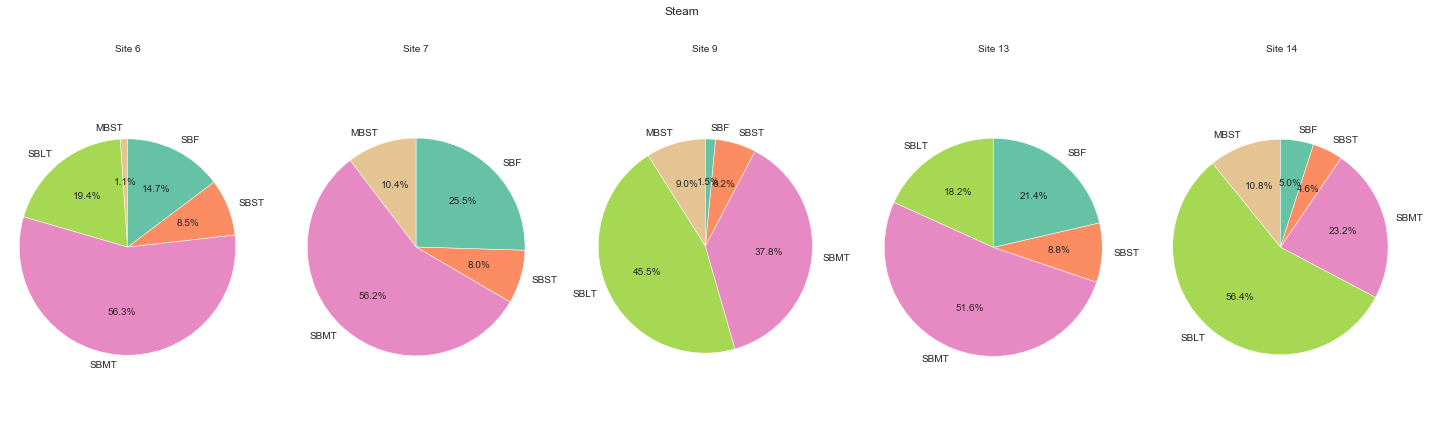

In [16]:
# Plot all sites in one figure
sites = list(errors.site_id.unique())
rows = 1
cols = len(sites)//rows
fig, axes = plt.subplots(rows, cols, figsize=(cols*5,7))
axes = axes.flatten()

for i,site in enumerate(sites):
    # Filter site data
    temp = errors[errors.site_id == site]
    # Create palette for number of categories
    errors_list = list(temp.error)
    pal = choose_palette_pie(errors_list)

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [ref[x] for x in list(temp.error)]
    sizes = list(temp.total_count)
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, colors = pal)
    ax.set_title(f"Site {site}", fontsize=10)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#fig.delaxes(axes[-1])
fig.suptitle(f"{meter.capitalize()}")
fig.savefig(path_fig + f"{meter}_pieplot_allSites.png", dpi=150, bbox_inches="tight")

plt.show()


SITE: 0
METER: chilledwater
Site 0 not available.
METER: electricity
Site 0 not available.
METER: hotwater
Site 0 not available.
METER: steam
Site 0 not available.


<Figure size 1080x360 with 0 Axes>


SITE: 1
METER: chilledwater
Site 1 not available.
METER: electricity
Site 1 not available.
METER: hotwater
Site 1 error's dataframe created.
METER: steam
Site 1 not available.


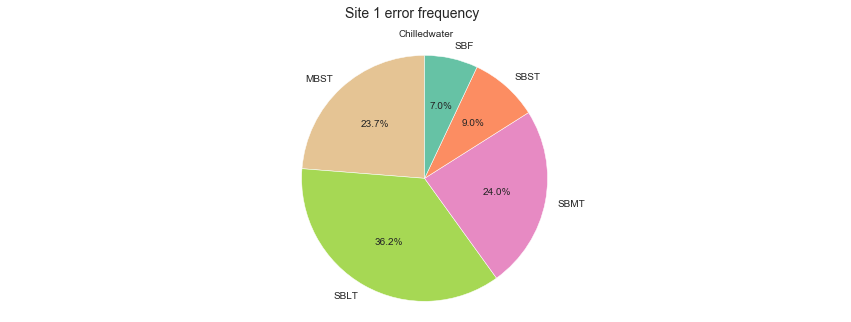


SITE: 2
METER: chilledwater
Site 2 not available.
METER: electricity
Site 2 not available.
METER: hotwater
Site 2 not available.
METER: steam
Site 2 not available.


<Figure size 1080x360 with 0 Axes>


SITE: 3
METER: chilledwater
Site 3 not available.
METER: electricity
Site 3 error's dataframe created.
METER: hotwater
Site 3 not available.
METER: steam
Site 3 not available.


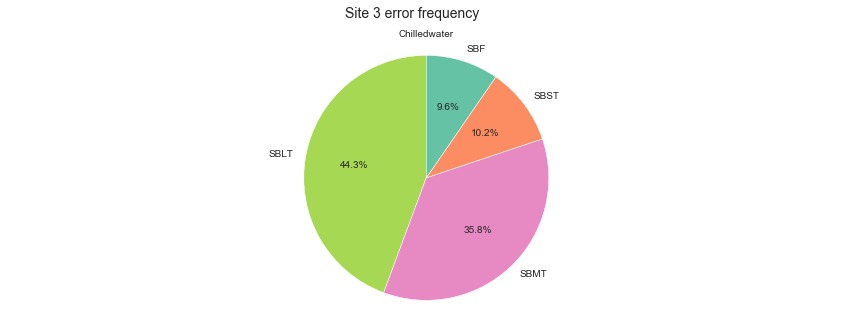


SITE: 4
METER: chilledwater
Site 4 not available.
METER: electricity
Site 4 not available.
METER: hotwater
Site 4 not available.
METER: steam
Site 4 not available.


<Figure size 1080x360 with 0 Axes>


SITE: 5
METER: chilledwater
Site 5 not available.
METER: electricity
Site 5 not available.
METER: hotwater
Site 5 not available.
METER: steam
Site 5 not available.


<Figure size 1080x360 with 0 Axes>


SITE: 6
METER: chilledwater
Site 6 error's dataframe created.
METER: electricity
Site 6 error's dataframe created.
METER: hotwater
Site 6 not available.
METER: steam
Site 6 error's dataframe created.


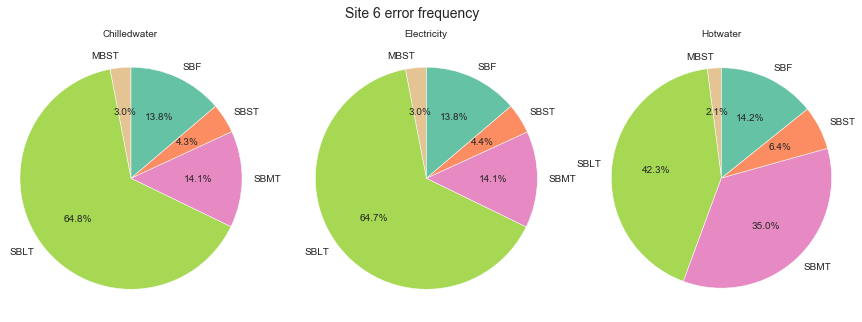


SITE: 7
METER: chilledwater
Site 7 error's dataframe created.
METER: electricity
Site 7 error's dataframe created.
METER: hotwater
Site 7 error's dataframe created.
METER: steam
Site 7 error's dataframe created.


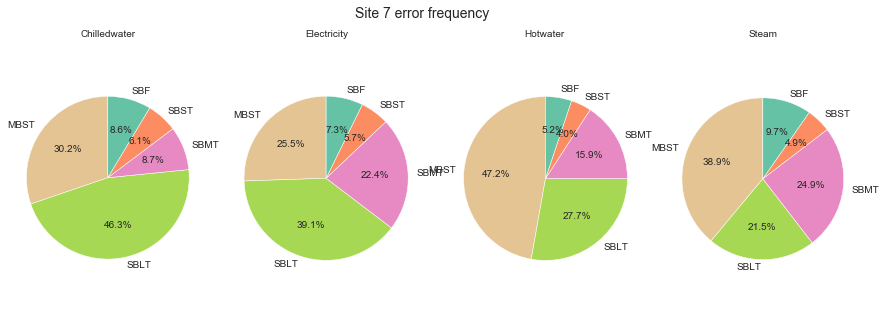


SITE: 8
METER: chilledwater
Site 8 not available.
METER: electricity
Site 8 error's dataframe created.
METER: hotwater
Site 8 not available.
METER: steam
Site 8 not available.


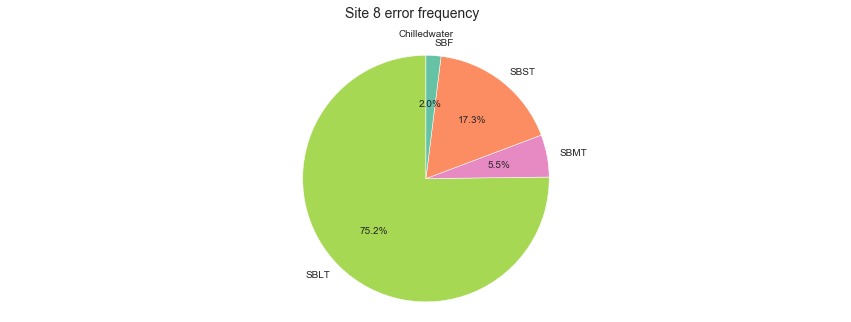


SITE: 9
METER: chilledwater
Site 9 error's dataframe created.
METER: electricity
Site 9 error's dataframe created.
METER: hotwater
Site 9 not available.
METER: steam
Site 9 error's dataframe created.


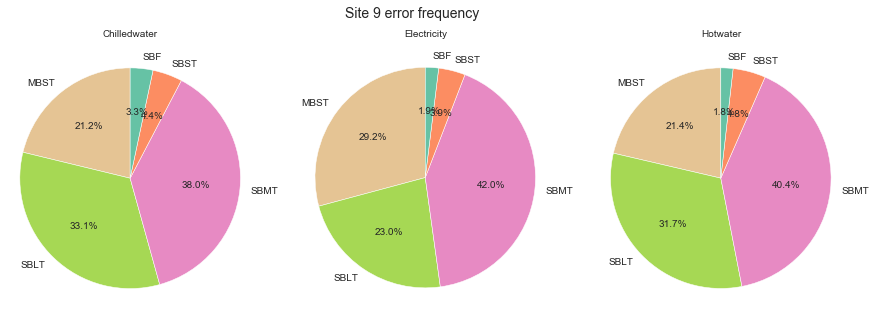

In [16]:
# Plots all meters by site
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
meters = ["chilledwater","electricity","hotwater","steam"]

for site in sites:
    print(f"\nSITE: {site}")

    errors_dfs = []
    dfs = []

    for meter in meters:
        print(f"METER: {meter}")  

        # create errors df
        try:
            df_error, error_types = error_df(path_res, meter, site)
        except:
            print(f"Site {site} not available.")
            continue

        # Melt df
        df_melt = df_error.reset_index().melt(id_vars="building_id", var_name="timestamp")
        # Filter errors
        df_melt = df_melt[df_melt.value != 0]
        # Add meter & site id
        df_melt["site_id"] = site
        df_melt["meter"] = meter

        # Add to list
        dfs.append(df_melt)

        errors = pd.concat(dfs)
        errors.timestamp = pd.to_datetime(errors.timestamp, format="%Y-%m-%d")
        errors.rename(columns={"value":"error"},inplace=True)

        # Group for pieplot
        errors = pd.DataFrame(errors.groupby(["site_id","error"])["building_id"].count()).rename(columns={"building_id":"total_count"}).reset_index()
        errors_dfs.append(errors)

    # Plot
    rows = 1
    cols = len(errors_dfs)
    plots = rows * cols

    fig, axes = plt.subplots(rows, cols, figsize=(15,5))
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df, meter in zip(errors_dfs, meters):
        # Create palette for number of categories
        errors_list = list(df["error"])
        pal = choose_palette_pie(errors_list)

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = [ref[x] for x in list(df.error)]
        sizes = list(df.total_count)
        
        ax =axes[i] if plots > 1 else axes
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, colors = pal)
        ax.set_title(f"{meter.capitalize()}", fontsize=10)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        i = i+1

    fig.suptitle(f"Site {site} error frequency", fontsize=14)
    plt.show()

    fig.savefig(path_fig + f"site{site}_allmeters_frequency_pieplot.pdf", dpi=150, bbox_inches="tight")
    fig.savefig(path_fig + f"site{site}_allmeters_frequency_pieplot.png", dpi=150, bbox_inches="tight")

## RMSLE sum by site

In [43]:
meter = "steam"

## Create errros dataframe
#  get sites
sites = get_sites(path_data,path_meta,meter)

# Empty list to save dfs
dfs = []

for site in sites:
    # create errors df
    try:
        df_error, error_types = error_df(path_res, meter, site)
    except:
        print(f"Site {site} not available.")
        continue

    # Melt df
    df_melt = df_error.reset_index().melt(id_vars="building_id", var_name="timestamp")
    # Filter errors
    df_melt = df_melt[df_melt.value != 0]
    # Add site_id
    df_melt["site_id"] = site

    # Add to list
    dfs.append(df_melt)

errors = pd.concat(dfs)
errors.timestamp = pd.to_datetime(errors.timestamp, format="%Y-%m-%d")
errors.rename(columns={"value":"error"},inplace=True)

## Load RMSLE dataframe
df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")

## Merge
rmsle = pd.merge(errors, df, how="left", on=["building_id","timestamp"])

## Sums RMSLE metric for each error type in site
sums = pd.DataFrame(rmsle.groupby(["site_id","error"])["rmsle"].sum()).reset_index()

del(errors,df,rmsle)

sites: 6. Buildings: 324
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 9 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 error's dataframe created.


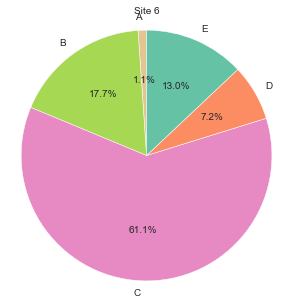

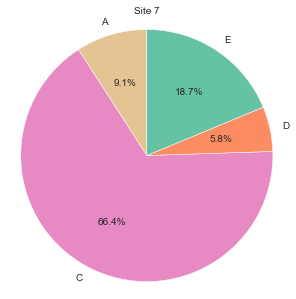

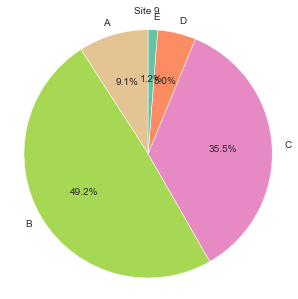

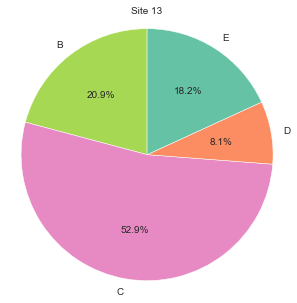

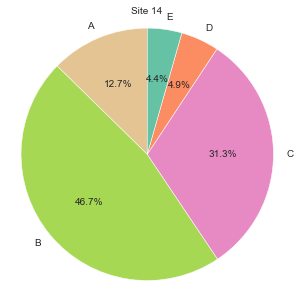

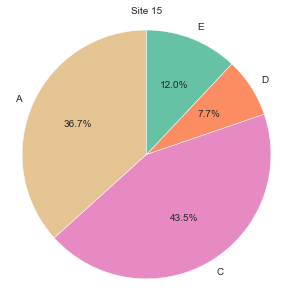

In [44]:
# Plot each individually
sites = list(sums.site_id.unique())

for i,site in enumerate(sites):
    # Filter site data
    temp = sums[sums.site_id == site]
    # Create palette for number of categories
    errors_list = list(temp.error)
    pal = choose_palette_pie(errors_list)

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [ref[x] for x in list(temp.error)]
    sizes = list(temp.rmsle)
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, colors = pal)
    ax.set_title(f"Site {site}", fontsize=10)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    fig.savefig(path_fig + f"{meter}_site{site}_RMSLE_pieplot.pdf", dpi=150, bbox_inches="tight")
    fig.savefig(path_fig + f"{meter}_site{site}_RMSLE_pieplot.png", dpi=150, bbox_inches="tight")

plt.show()


SITE: 0
METER: chilledwater
Site 0 not available.
METER: electricity
Site 0 not available.
METER: hotwater
Site 0 not available.
METER: steam
Site 0 not available.


<Figure size 1080x360 with 0 Axes>


SITE: 1
METER: chilledwater
Site 1 not available.
METER: electricity
Site 1 error's dataframe created.
METER: hotwater
Site 1 error's dataframe created.
METER: steam
Site 1 not available.


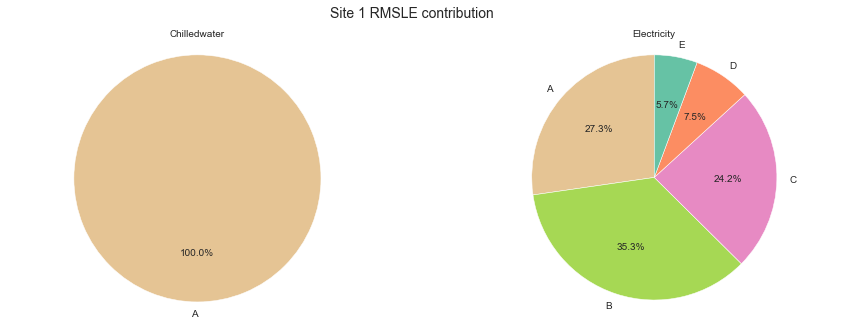


SITE: 2
METER: chilledwater
Site 2 error's dataframe created.
METER: electricity
Site 2 not available.
METER: hotwater
Site 2 not available.
METER: steam
Site 2 not available.


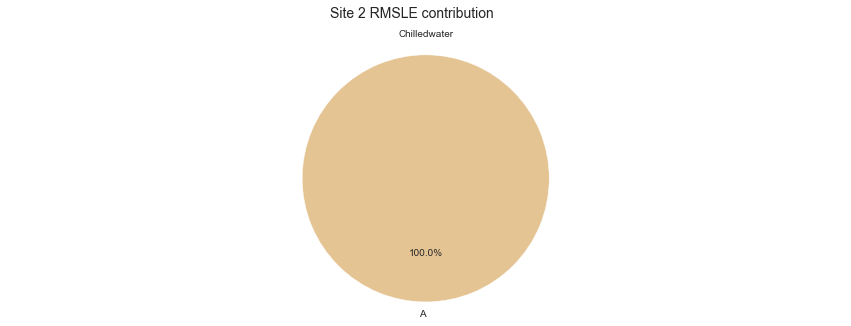


SITE: 3
METER: chilledwater
Site 3 not available.
METER: electricity
Site 3 error's dataframe created.
METER: hotwater
Site 3 not available.
METER: steam
Site 3 not available.


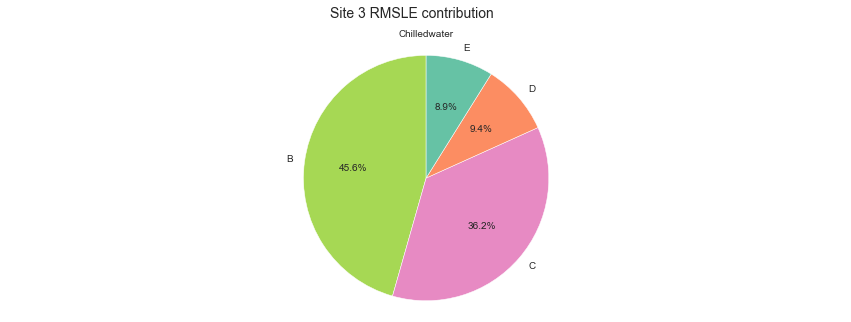


SITE: 4
METER: chilledwater
Site 4 not available.
METER: electricity
Site 4 not available.
METER: hotwater
Site 4 not available.
METER: steam
Site 4 not available.


<Figure size 1080x360 with 0 Axes>


SITE: 5
METER: chilledwater
Site 5 not available.
METER: electricity
Site 5 error's dataframe created.
METER: hotwater
Site 5 not available.
METER: steam
Site 5 not available.


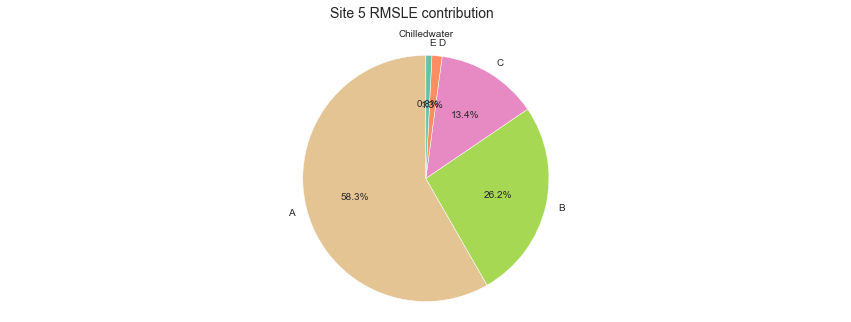


SITE: 6
METER: chilledwater
Site 6 error's dataframe created.
METER: electricity
Site 6 error's dataframe created.
METER: hotwater
Site 6 not available.
METER: steam
Site 6 error's dataframe created.


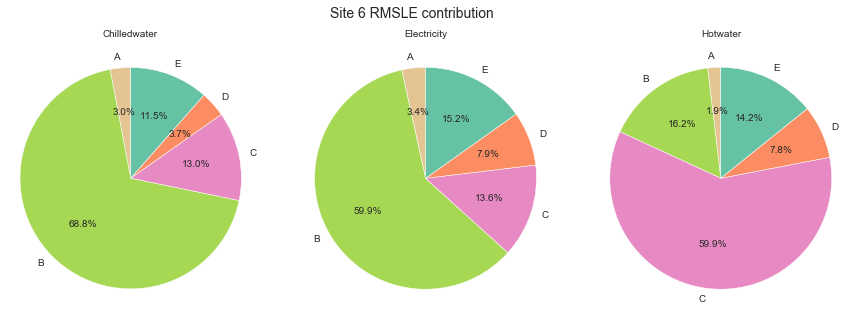


SITE: 7
METER: chilledwater
Site 7 error's dataframe created.
METER: electricity
Site 7 error's dataframe created.
METER: hotwater
Site 7 error's dataframe created.
METER: steam
Site 7 error's dataframe created.


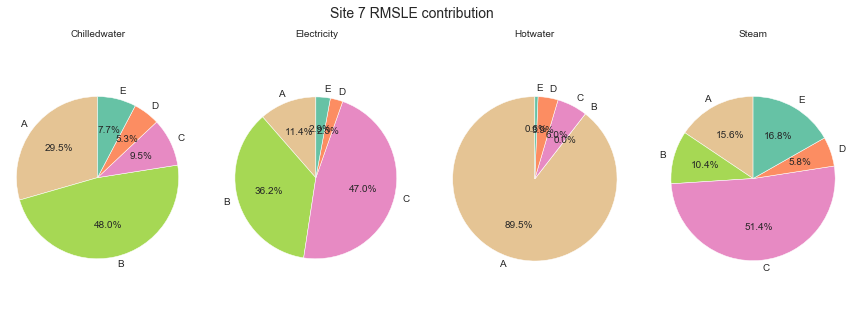


SITE: 8
METER: chilledwater
Site 8 not available.
METER: electricity
Site 8 error's dataframe created.
METER: hotwater
Site 8 not available.
METER: steam
Site 8 not available.


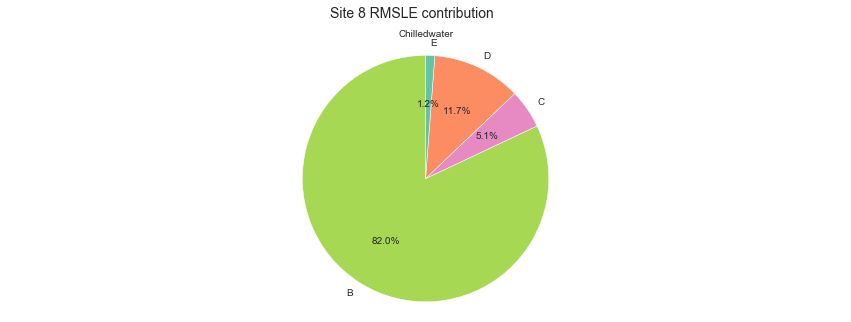


SITE: 9
METER: chilledwater
Site 9 error's dataframe created.
METER: electricity
Site 9 error's dataframe created.
METER: hotwater
Site 9 not available.
METER: steam
Site 9 error's dataframe created.


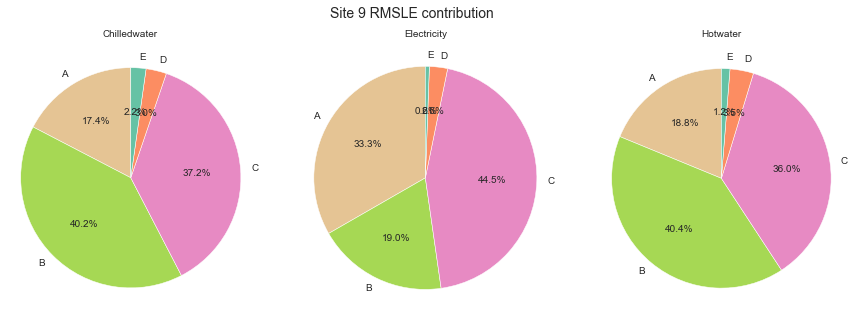


SITE: 10
METER: chilledwater
Site 10 error's dataframe created.
METER: electricity
Site 10 error's dataframe created.
METER: hotwater
Site 10 error's dataframe created.
METER: steam
Site 10 not available.


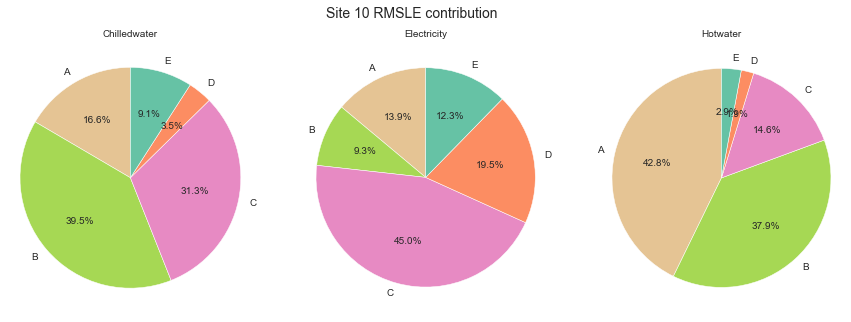


SITE: 11
METER: chilledwater
Site 11 error's dataframe created.
METER: electricity
Site 11 not available.
METER: hotwater
Site 11 error's dataframe created.
METER: steam
Site 11 not available.


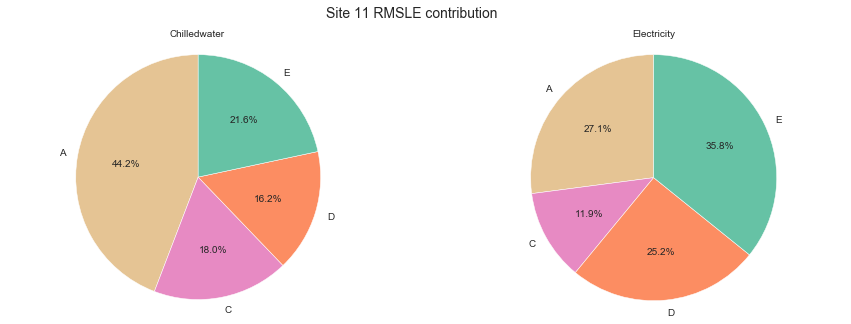


SITE: 12
METER: chilledwater
Site 12 not available.
METER: electricity
Site 12 error's dataframe created.
METER: hotwater
Site 12 not available.
METER: steam
Site 12 not available.


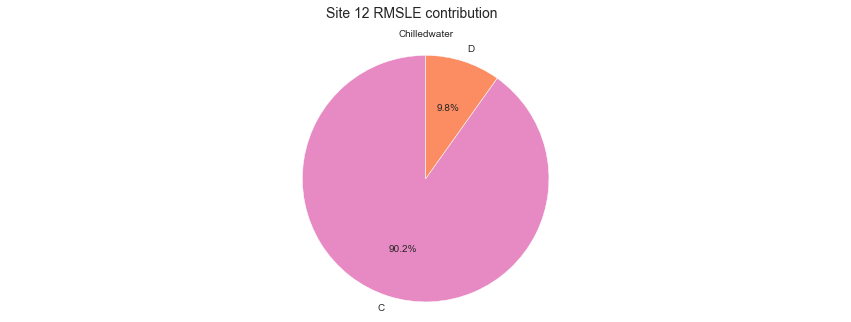


SITE: 13
METER: chilledwater
Site 13 error's dataframe created.
METER: electricity
Site 13 error's dataframe created.
METER: hotwater
Site 13 not available.
METER: steam
Site 13 error's dataframe created.


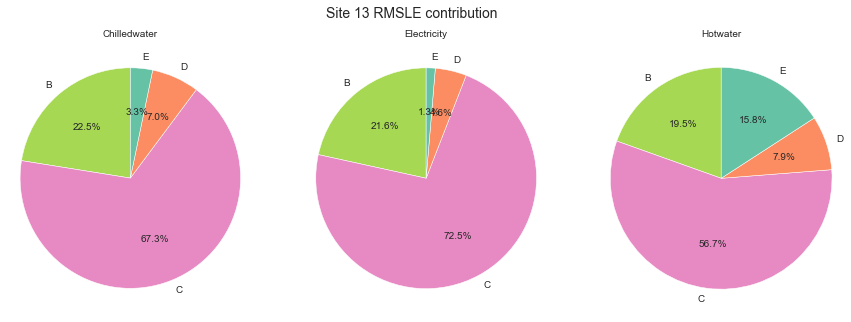


SITE: 14
METER: chilledwater
Site 14 error's dataframe created.
METER: electricity
Site 14 error's dataframe created.
METER: hotwater
Site 14 error's dataframe created.
METER: steam
Site 14 error's dataframe created.


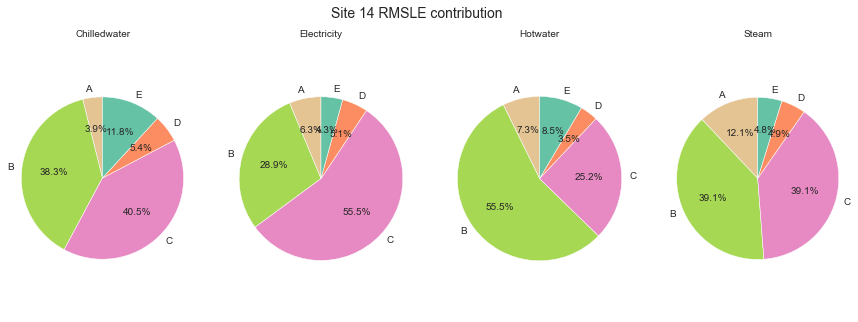


SITE: 15
METER: chilledwater
Site 15 error's dataframe created.
METER: electricity
Site 15 not available.
METER: hotwater
Site 15 error's dataframe created.
METER: steam
Site 15 error's dataframe created.


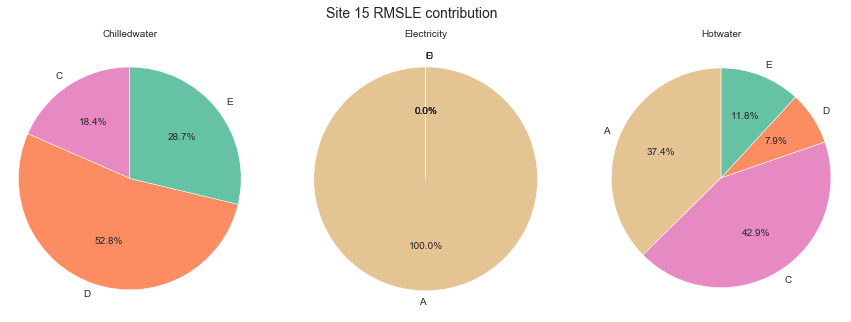

In [9]:
# Plots all meters by site
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
meters = ["chilledwater","electricity","hotwater","steam"]

for site in sites:
    print(f"\nSITE: {site}")

    rmsle_list = []
    dfs = []

    for meter in meters:
        print(f"METER: {meter}")  

        # create errors df
        try:
            df_error, error_types = error_df(path_res, meter, site)
        except:
            print(f"Site {site} not available.")
            continue

        # Melt df
        df_melt = df_error.reset_index().melt(id_vars="building_id", var_name="timestamp")
        # Filter errors
        df_melt = df_melt[df_melt.value != 0]
        # Add meter & site id
        df_melt["site_id"] = site
        df_melt["meter"] = meter

        # Add to list
        dfs.append(df_melt)

        errors = pd.concat(dfs)
        errors.timestamp = pd.to_datetime(errors.timestamp, format="%Y-%m-%d")
        errors.rename(columns={"value":"error"},inplace=True)

        ## Load RMSLE dataframe
        df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")
        df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")

        ## Merge
        rmsle = pd.merge(errors, df, how="left", on=["building_id","timestamp"])

        ## Sums RMSLE metric for each error type in site
        sums = pd.DataFrame(rmsle.groupby(["site_id","error"])["rmsle"].sum()).reset_index()
        rmsle_list.append(sums)

        del(errors,df,rmsle)

    # Plot
    rows = 1
    cols = len(rmsle_list)
    plots = rows * cols

    fig, axes = plt.subplots(rows, cols, figsize=(15,5))
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df, meter in zip(rmsle_list, meters):
        # Create palette for number of categories
        errors_list = list(df["error"])
        pal = choose_palette_pie(errors_list)

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = [ref[x] for x in list(df.error)]
        sizes = list(df.rmsle)
        
        ax =axes[i] if plots > 1 else axes
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, colors = pal)
        ax.set_title(f"{meter.capitalize()}", fontsize=10)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        i = i+1

    fig.suptitle(f"Site {site} RMSLE contribution", fontsize=14)
    plt.show()

    fig.savefig(path_fig + f"site{site}_allmeters_RMSLE_pieplot.pdf", dpi=150, bbox_inches="tight")
    fig.savefig(path_fig + f"site{site}_allmeters_RMSLE_pieplot.png", dpi=150, bbox_inches="tight")

## Plot selected sites

In [12]:
def sites_to_plot(meter):

    if (meter == "chilledwater") or (meter == "steam"):
        sites = [9,13,14]
    elif meter == "electricity":
        sites = [5,9,14]
    elif meter == "hotwater":
        sites = [1,10,14]
    
    return sites

In [23]:
#Create dfs
meter = "steam"

## Create errros dataframe
#  get sites
sites = sites_to_plot(meter)

# Empty list to save dfs
dfs = []

for site in sites:
    # create errors df
    try:
        df_error, error_types = error_df(path_res, meter, site)
    except:
        print(f"Site {site} not available.")
        continue

    # Melt df
    df_melt = df_error.reset_index().melt(id_vars="building_id", var_name="timestamp")
    # Filter errors
    df_melt = df_melt[df_melt.value != 0]
    # Add site_id
    df_melt["site_id"] = site

    # Add to list
    dfs.append(df_melt)

errors = pd.concat(dfs)
errors.timestamp = pd.to_datetime(errors.timestamp, format="%Y-%m-%d")
errors.rename(columns={"value":"error"},inplace=True)

# Group for pieplot
errors = pd.DataFrame(errors.groupby(["site_id","error"])["building_id"].count()).rename(columns={"building_id":"total_count"}).reset_index()

Site 9 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.


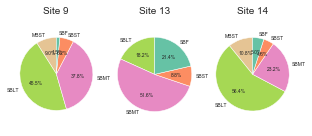

In [24]:
# Plot
sites = sites_to_plot(meter)
fig, axes = plt.subplots(1, len(sites), figsize=(5,2))
axes = axes.flatten()

for i,site in enumerate(sites):
    # Filter site data
    temp = errors[errors.site_id == site]
    # Create palette for number of categories
    errors_list = list(temp.error)
    pal = choose_palette_pie(errors_list)

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [ref[x] for x in list(temp.error)]
    sizes = list(temp.total_count)
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, colors = pal, textprops={'fontsize': 5})
    ax.set_title(f"Site {site}", fontsize=10)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#fig.suptitle(f"{meter.capitalize()}", fontsize=14)
plt.show()

fig.savefig(path_fig + f"{meter}_pieplot_selectedSites.pdf", dpi=150, bbox_inches="tight")
fig.savefig(path_fig + f"{meter}_pieplot_selectedSites.png", dpi=150, bbox_inches="tight")